In [1]:
from WingWatch.Intersections.detection import Detection
from WingWatch.Intersections import tri
import trimesh
import pandas as pd
import numpy as np
import WingWatch.Intersections.physicalTrackLimiter as PTL
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Tools import translation,spheres
from WingWatch.Tools import point_check as pc
import matplotlib.pyplot as plt
import scipy.spatial as ss

test_data_file = 'Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)


Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)
Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)

Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


/home/main/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1 added to Station_1's antennas.
1 added to Station_2's antennas.
1 added to Station_3's antennas.


In [2]:
df_detections = pd.read_csv('straight_walk_Detections.csv')
df_walk = pd.read_csv('straight_walk.csv')


#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent = []
cy_cent = []
for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cz = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,2])
    cx_cent.append(cx)
    cy_cent.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


#g should be the same value as the len of the detections

In [3]:
import WingWatch.Tools.spheres as sph

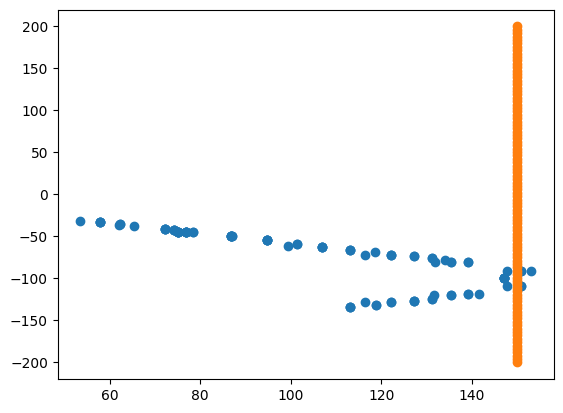

In [4]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

In [5]:
cx_appv = cx_cent[0:3]
cy_appv = cy_cent[0:3]

radius_list_oldest = []
for i in range(len(points_to_follow)):
    V = ss.ConvexHull(points_to_follow[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list_oldest.append(radius)


In [6]:
cx_new = []
cy_new = []
points_to_follow_new = [points_to_follow[0]]
cx_new.append(cx_cent[0])
cy_new.append(cy_cent[0])

i = 1

intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],16,i)
points_to_follow_new.append(intersections)


radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)


In [7]:
radius_list

[236.87095058180003, 228.31337121750343]

In [8]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(len(points_to_follow)):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        points_to_follow_new.append(points_to_follow[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow_new[i-1],points_to_follow[i],5,1)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [9]:
i

99

In [10]:
radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)

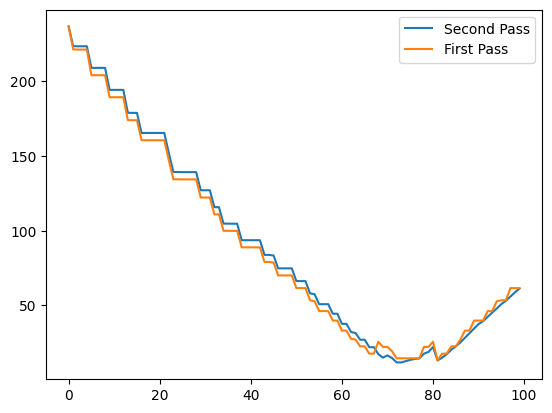

In [11]:
plt.plot(radius_list,label='Second Pass')
plt.plot(radius_list_oldest,label='First Pass')
plt.legend()

In [12]:
cx_new = []
cy_new = []
points_to_follow_three = []

for i in range(len(points_to_follow)):
    if i == 0 or i == 1: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        points_to_follow_three.append(points_to_follow[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints_two_region(points_to_follow_three[i-2],points_to_follow_three[i-1],points_to_follow[i],5,1)
    points_to_follow_three.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [13]:
len(points_to_follow)

100

In [14]:
radius_list_3 = []
for i in range(len(points_to_follow_three)):
    V = ss.ConvexHull(points_to_follow_three[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list_3.append(radius)

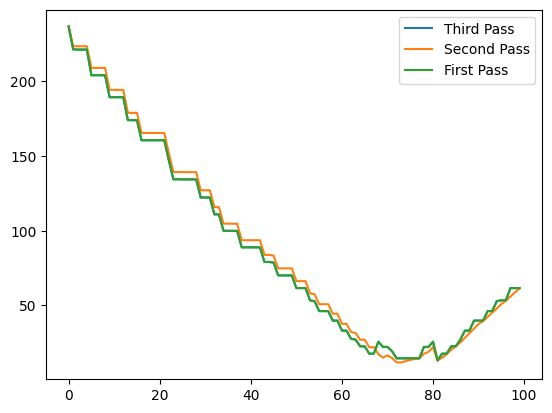

In [15]:
plt.plot(radius_list_3,label='Third Pass')
plt.plot(radius_list,label='Second Pass')
plt.plot(radius_list_oldest,label='First Pass')
plt.legend()

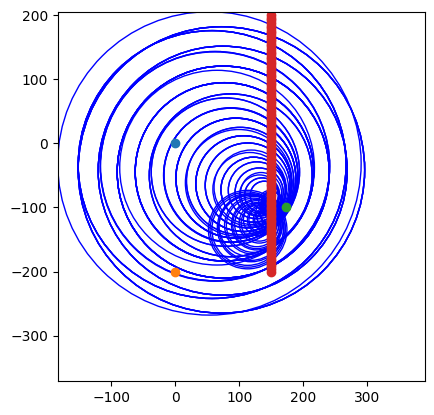

In [16]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent
y_coords = cy_cent
radii = radius_list

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

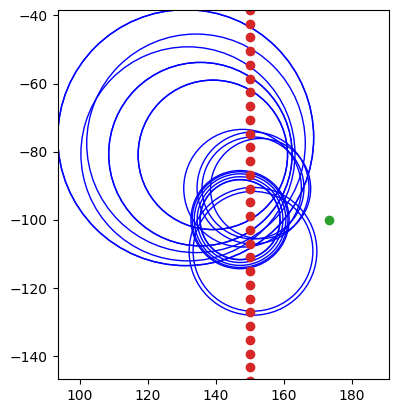

In [17]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent[60:80]
y_coords = cy_cent[60:80]
radii = radius_list[60:80]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

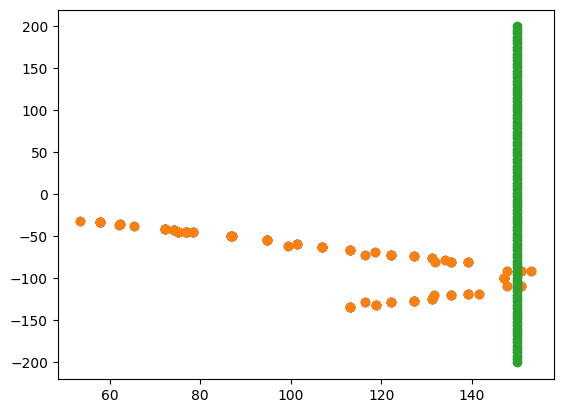

In [18]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(cx_new,cy_new)
plt.scatter(df_walk.X,df_walk.Y)

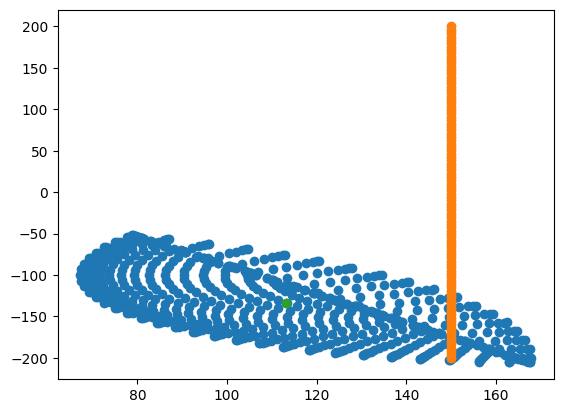

In [19]:
plt.scatter(intersections[:,0],intersections[:,1])

cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])

#plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

plt.scatter(cx,cy)

In [20]:
df_detections.idxmin()

Unnamed: 0     0
Station 1     32
Station 2     81
Station 3     71
dtype: int64

In [21]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(71,len(points_to_follow)):
    #for i in range(3):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],5,i)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [22]:
radius_list_new = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list_new.append(radius)

In [23]:
radius_list_new

[22.13143901792899,
 19.26671947337471,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 22.131444603374387,
 22.131444603374387,
 25.5964327306142,
 25.5964327306142,
 17.61751496660148,
 17.61751496660148,
 22.515663508407727,
 22.515663508407727,
 27.004973089555033,
 33.05446503438392,
 33.05446503438392,
 39.777909394426146,
 39.777909394426146,
 39.777909394426146,
 46.129647924138006,
 46.129647924138006,
 52.77779625213469,
 53.35516400738245,
 53.35516400738245,
 61.544412919143554,
 61.544412919143554,
 61.544412919143554]

In [24]:
radius_list_new

[22.13143901792899,
 19.26671947337471,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 22.131444603374387,
 22.131444603374387,
 25.5964327306142,
 25.5964327306142,
 17.61751496660148,
 17.61751496660148,
 22.515663508407727,
 22.515663508407727,
 27.004973089555033,
 33.05446503438392,
 33.05446503438392,
 39.777909394426146,
 39.777909394426146,
 39.777909394426146,
 46.129647924138006,
 46.129647924138006,
 52.77779625213469,
 53.35516400738245,
 53.35516400738245,
 61.544412919143554,
 61.544412919143554,
 61.544412919143554]

In [25]:
radius_list[70:]

[16.441544827520058,
 14.714309759440894,
 11.782347215211963,
 11.70642080183341,
 12.598108619719943,
 13.454828839053828,
 14.068632547967894,
 14.429022265270829,
 17.595133197953277,
 18.77122816473643,
 22.083336610314586,
 13.050549496017785,
 14.918244091027802,
 17.24684980992716,
 20.239974856115463,
 22.499498533239898,
 25.152500880195557,
 28.22879883653385,
 31.31814132608071,
 34.39000364946192,
 37.44964216691302,
 39.42137983601276,
 42.29910818485554,
 45.12368575761115,
 47.87513593264219,
 50.81760424886293,
 53.03621364898046,
 55.87625769288081,
 58.730248036924955,
 61.30091587773777]

In [26]:
radius_list_oldest[70:]

[22.13143902039337,
 19.26671947423845,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 14.492856276176797,
 22.131444604037092,
 22.131444604037092,
 25.596432736210595,
 13.044088925558244,
 17.61751496660148,
 17.61751496660148,
 22.51566351215522,
 22.51566351215522,
 27.004973131647475,
 33.054465038221586,
 33.054465038221586,
 39.777909394426146,
 39.777909394426146,
 39.777909394426146,
 46.12964793092858,
 46.12964793092858,
 52.77779625307485,
 53.355164008352446,
 53.355164008352446,
 61.544412920558166,
 61.544412920558166,
 61.544412920558166]